In [1]:
import pandas as pd
import scipy as sci
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, signal
from scipy.signal import butter, lfilter
import datetime
from scipy.signal import iirfilter
%matplotlib inline

In [2]:
TP_L = 0
IF_L = 1
IF_R = 2
TP_R = 3
BASELINE = 4
channal_name = []
channal_name.append("TP_L")
channal_name.append("IF_L")
channal_name.append("IF_R")
channal_name.append("TP_R")
channal_name.append("BASELINE")

In [3]:
eegF1_df = pd.read_json('file:eegData_F1.json')
eegF2_df = pd.read_json('file:eegData_F2.json')
eegF3_df = pd.read_json('file:eegData_F3.json')
eegM1_df = pd.read_json('file:eegData_M1.json')
eegM2_df = pd.read_json('file:eegData_M2.json')
eegM3_df = pd.read_json('file:eegData_M3.json')
eegM4_df = pd.read_json('file:eegData_M4.json')
eegM5_df = pd.read_json('file:eegData_M5.json')

eventF1_df = pd.read_json('file:Event_F1.json')
eventF2_df = pd.read_json('file:Event_F2.json')
eventF3_df = pd.read_json('file:Event_F3.json')
eventM1_df = pd.read_json('file:Event_M1.json')
eventM2_df = pd.read_json('file:Event_M2.json')
eventM3_df = pd.read_json('file:Event_M3.json')
eventM4_df = pd.read_json('file:Event_M4.json')
eventM5_df = pd.read_json('file:Event_M5.json')

accelF1_df = pd.read_json('file:accelerometerJson_F1.json')
accelM1_df = pd.read_json('file:accelerometerJson_M1.json')
fs = 256
eventM1_df = eventM1_df[['value', 'timestamp']]
participants_eeg = [eegF2_df, eegF3_df, eegM3_df, eegM4_df,eegM5_df]
participants_event = [eventF2_df,eventF3_df,eventM3_df,eventM4_df,eventM5_df]

In [4]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def notch_filter_60hz(data, fs, band_width=2, freq=60, order=3, filter_type='butter'):
    nyq  = fs/2.0
    low  = freq - band_width/2.0
    high = freq + band_width/2.0
    low  = low/nyq
    high = high/nyq
    b, a = iirfilter(order, [low, high], btype='bandstop',
                     analog=False, ftype=filter_type)
    filtered_data = lfilter(b, a, data)
    return filtered_data


def clean_data(data, fs):
    mean = np.mean(data)
    data = data - mean
#    data = notch_filter_60hz(data,fs)
    data = butter_bandpass_filter(data, .5, 15, fs)
    return data

def discard_first_trial(eventlist):
    eventlist = np.delete(eventlist,0,1)
    return eventlist

In [5]:
def datetime_to_float(d):
    epoch = datetime.datetime.utcfromtimestamp(0)
    total_seconds =  (d - epoch).total_seconds()
    # total_seconds will be in decimals (millisecond precision)
    return total_seconds

def compute_EEG_indices(event_timestamps, fs):
    indices = np.array([int(i * fs) for i in event_timestamps]).astype(int)
    return indices

def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

In [6]:
def process_eeg_dataframe(df):
    df_raw_time_vector = df[df['electrode'] == 0]['timestamp'].to_numpy()
    time_spacing = []
    
    for i in np.arange(1,len(df_raw_time_vector)):
        time_spacing.append(df_raw_time_vector[i]-df_raw_time_vector[i-1])

        if(i>1):
            if(not time_spacing[i-1] == time_spacing[i-2]):
                print(time_spacing[i-1],time_spacing[i-2])

    dt_stamp = time_spacing[0]
    dt = dt_stamp / np.timedelta64(1, 's')
    
    T = df_raw_time_vector[-1] - df_raw_time_vector[0] + dt_stamp
    T = T / np.timedelta64(1, 's')

    time_vector = np.arange(0,T,dt/12)
    
    channel_list = []
    eeg_channels = []
    for channel in np.arange(5):
        channel_list.append(df[df['electrode'] == channel])
        eeg_temp = channel_list[channel]['samples'].tolist()
        eeg = []
        for a in eeg_temp:
            for b in a:
                eeg.append(b)
        eeg_channels.append(clean_data(np.array(eeg),fs))
#        print('shape of channel ',channel,': ',eeg_channels[channel].shape)
    eeg_channels = np.array(eeg_channels).squeeze()
    return time_vector,eeg_channels,T

In [7]:
def process_event_dataframe(df,start_time):
    data = df.to_numpy()
    for i in np.arange(len(data)):
        data[i,1] = (datetime_to_float(df["timestamp"][i]) - start_time)
    return data.T

def first_timestamp(df):
    timestamp = df['timestamp'][0]
    return timestamp

In [8]:
def grab_epoch(data, index, fs, len_pre, len_post):
    epoch = np.array([i for i in data[(index+int(len_pre*fs) if index+int(len_pre*fs) >= 0 else 0):index+(len_post*fs)]])
    return epoch

def get_windows(data, indices, fs, len_pre, len_post):
    epoch_list = []
    for index in indices:
        epoch = []
        if index+int(len_pre*fs) < 0 or index+int(len_post*fs) >= len(data): 
            continue
        start = index+int(len_pre*fs) 
        end = index+int(len_post*fs)
        baseline = np.mean(data[start:index])
#        normalizer = np.mean(np.abs(data[start:index]))
        for value in data[start:end]:
            epoch.append(value - baseline)
#        normalizer = np.mean(np.abs(data[start:index]))
#        for i in len(epoch):
#            epoch[i] = epoch[i]/normalizer
        if(np.var(epoch) > 200):
            continue
        epoch_list.append(epoch)
    return np.array(epoch_list)

In [9]:
time_vector_list = []
eeg_list = []
length_list = []
event_list = []

for i in np.arange(len(participants_eeg)):
#    print(i)
    time_vector,eeg,T = process_eeg_dataframe(participants_eeg[i])
    time_vector_list.append(time_vector)
    eeg_list.append(eeg)
    length_list.append(T)
    event = process_event_dataframe(participants_event[i],datetime_to_float(first_timestamp(participants_eeg[i])))
    event[1] = compute_EEG_indices(event[1], fs)
    event = discard_first_trial(event)
    event_list.append(event)

In [10]:
M1_offset = datetime_to_float(eventM1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM1_df))
M2_offset = datetime_to_float(eventM2_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM2_df))
M3_offset = datetime_to_float(eventM3_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM3_df))
M4_offset = datetime_to_float(eventM4_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM4_df))
M5_offset = datetime_to_float(eventM5_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM5_df))
F1_offset = datetime_to_float(eventF1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF1_df))
F2_offset = datetime_to_float(eventF2_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF2_df))
F3_offset = datetime_to_float(eventF3_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF3_df))

print('M1 offset: ' + str(M1_offset))
print('M2 offset: ' + str(M2_offset))
print('M3 offset: ' + str(M3_offset))
print('M4 offset: ' + str(M4_offset))
print('M5 offset: ' + str(M5_offset))
print('F1 offset: ' + str(F1_offset))
print('F2 offset: ' + str(F2_offset))
print('F3 offset: ' + str(F3_offset))

target_offset = (M3_offset + M4_offset)/2
print('Target offset: ' + str(target_offset))

m3_offset_shift = target_offset - M3_offset
m4_offset_shift = target_offset - M4_offset

m3_index_shift = int(fs * m3_offset_shift)
m4_index_shift = int(fs * m4_offset_shift)

print(m3_index_shift)
print(m4_index_shift)

# note: fix indices for M3 and M4

M1 offset: 11.270625114440918
M2 offset: 11.25
M3 offset: -3165.8001251220703
M4 offset: 3174.6126248836517
M5 offset: 4.40625
F1 offset: 611.2706251144409
F2 offset: 4.40625
F3 offset: 4.453125
Target offset: 4.4062498807907104
811572
-811572


In [11]:
print(event_list[2][1])
event_list[2][1] = event_list[2][1] + m3_index_shift
print(event_list[2][1])

[-809316 -808176 -807048 -805908 -804780 -803652 -802512 -801384 -800244
 -799116 -797988 -796848 -795720 -794580 -793452 -792324 -791184 -790056
 -788916 -787788 -786660 -785520 -784392 -783252 -782124 -780996 -779856
 -778728 -777588 -776460 -775332 -774192 -773064 -771924 -770796 -769668
 -768528]
[2256 3396 4524 5664 6792 7920 9060 10188 11328 12456 13584 14724 15852
 16992 18120 19248 20388 21516 22656 23784 24912 26052 27180 28320 29448
 30576 31716 32844 33984 35112 36240 37380 38508 39648 40776 41904 43044]


In [12]:
print(event_list[3][1])
event_list[3][1] = event_list[3][1] + m4_index_shift
print(event_list[3][1])

[813828 814968 816096 817224 818364 819492 820632 821760 822888 824028
 825156 826296 827424 828552 829692 830820 831960 833088 834216 835356
 836484 837624 838752 839880 841020 842148 843288 844416 845544 846684
 847812 848952 850080 851208 852348 853476 854616]
[2256 3396 4524 5652 6792 7920 9060 10188 11316 12456 13584 14724 15852
 16980 18120 19248 20388 21516 22644 23784 24912 26052 27180 28308 29448
 30576 31716 32844 33972 35112 36240 37380 38508 39636 40776 41904 43044]


In [50]:
len_pre = -1
len_post = 2

In [51]:
cat_index = []
snake_index = []

for i in np.arange(len(eeg_list)):
    cat_index.append([])
    snake_index.append([])            

epochs_cat = [[],[],[],[],[]]
epochs_snake = [[],[],[],[],[]]


for participant in np.arange(len(eeg_list)):
    for i in np.arange(len(event_list[participant][0])):
#        print(participant,i)
        if(event_list[participant][0][i] < 12):
            cat_index[participant].append(event_list[participant][1][i])
        else:
            snake_index[participant].append(event_list[participant][1][i])


for participant in np.arange(len(eeg_list)):
    for channel in np.arange(5):
        cat_windows = np.array(get_windows(eeg_list[participant][channel], cat_index[participant], fs, len_pre, len_post))
        cat_windows = cat_windows / np.mean(np.abs(cat_windows))
        snake_windows = np.array(get_windows(eeg_list[participant][channel], snake_index[participant], fs, len_pre, len_post))
        snake_windows = snake_windows / np.mean(np.abs(snake_windows))
        for epoch in cat_windows:
            epochs_cat[channel].append(epoch)
        for epoch in snake_windows:
            epochs_snake[channel].append(epoch)    
        
epochs_cat = np.array(epochs_cat)

epochs_snake = np.array(epochs_snake)


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [52]:
for channel in np.arange(5):
    for participant in np.arange(len(eeg_list)):
        cat_windows = np.array(get_windows(eeg_list[participant][channel], cat_index[participant], fs, len_pre, len_post))
        cat_windows = cat_windows / np.mean(np.abs(cat_windows))
        snake_windows = np.array(get_windows(eeg_list[participant][channel], snake_index[participant], fs, len_pre, len_post))
        snake_windows = snake_windows / np.mean(np.abs(snake_windows))
        for epoch in cat_windows:
            epochs_cat[channel].append(epoch)
        for epoch in snake_windows:
            epochs_snake[channel].append(epoch)    

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [53]:
#cat_index
#snake_index
#epochs_cat
#epochs_snake
print(np.array(epochs_cat[0]).shape)
print(np.array(epochs_snake[0]).shape)
print(np.mean(epochs_cat[0]))


(112, 768)
(48, 768)
0.012178541382035443


In [54]:
cat_average = []
snake_average = []
for channel in np.arange(5):
#    print(np.array(epochs_cat[channel]).shape)
    cat_average.append(np.mean(epochs_cat[channel], axis=0))
    snake_average.append(np.mean(epochs_snake[channel], axis=0))

cat_average= np.array(cat_average)
snake_average= np.array(snake_average)

epoch_time = np.arange(len_pre, len_post, 1/fs)

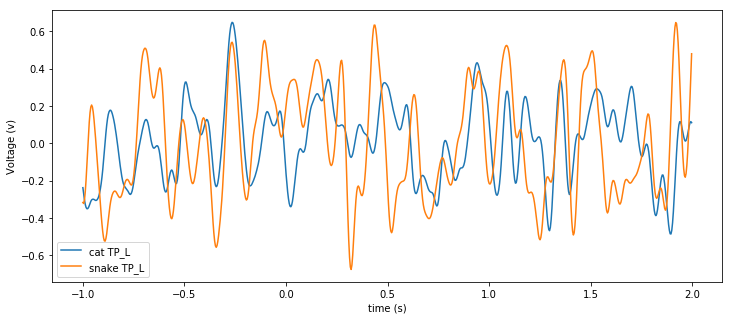

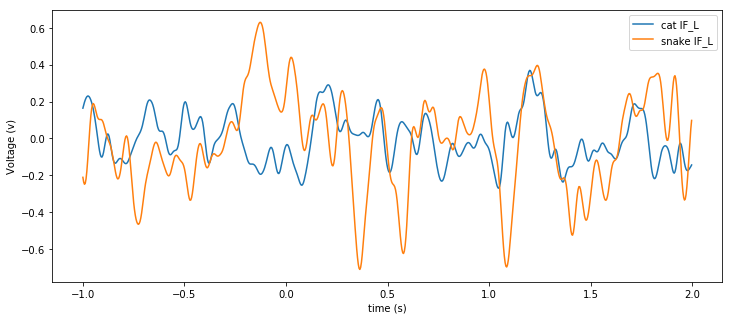

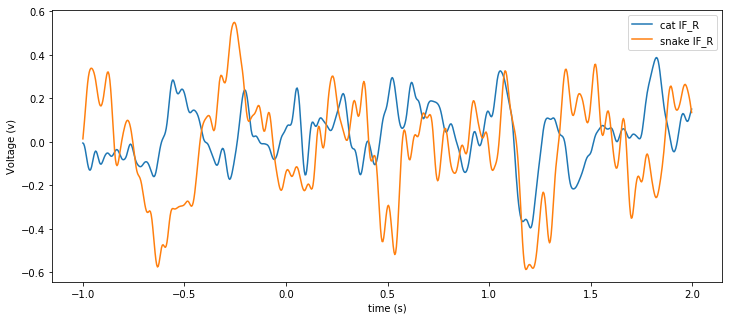

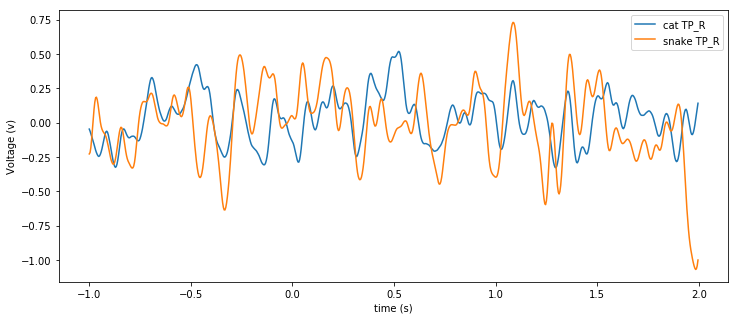

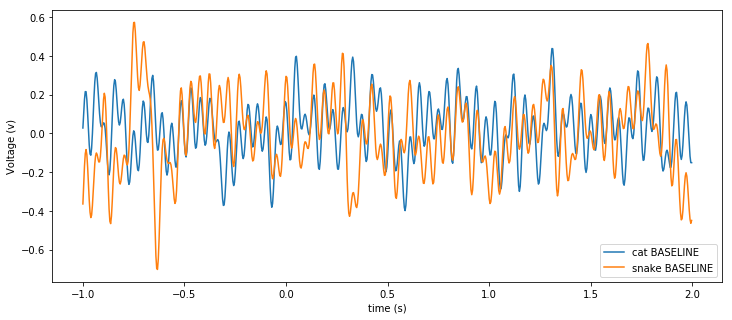

In [55]:
for i in range(0,len(channal_name)):
    # plot STA
    plt.figure(figsize=(12,5))
    plt.plot(epoch_time, cat_average[i], '-', label = "cat " + channal_name[i])
    plt.plot(epoch_time, snake_average[i], '-', label = "snake " + channal_name[i])
    plt.xlabel('time (s)'); plt.ylabel('Voltage (v)');
    plt.legend()


In [56]:
#post-stimulus
cat_fft_post = [np.fft.fft(cat_average[i][int(-len_pre*fs):]) for i in range(0,5)]
snake_fft_post = [np.fft.fft(snake_average[i][int(-len_pre*fs):]) for i in range(0,5)]

cat_power_post = [np.abs(cat_fft_post[i])**2 for i in range(0,5)]
snake_power_post = [np.abs(snake_fft_post[i])**2 for i in range(0,5)]

fft_freqs_post = np.fft.fftfreq(np.array(cat_fft_post).shape[-1],1/fs)

#pre-stimulus
cat_fft_pre = [np.fft.fft(cat_average[i][:int(-len_pre*fs)]) for i in range(0,5)]
snake_fft_pre = [np.fft.fft(snake_average[i][:int(-len_pre*fs)]) for i in range(0,5)]

cat_power_pre = [np.abs(cat_fft_pre[i])**2 for i in range(0,5)]
snake_power_pre = [np.abs(snake_fft_pre[i])**2 for i in range(0,5)]

fft_freqs_pre = np.fft.fftfreq(np.array(cat_fft_pre).shape[-1],1/fs)

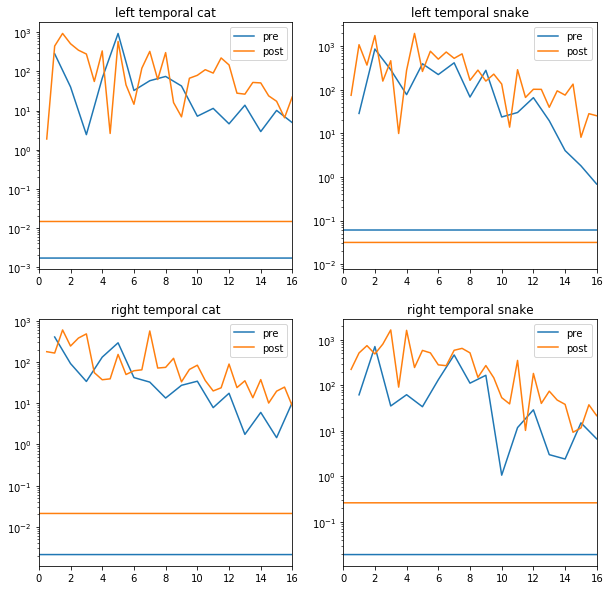

In [57]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(fft_freqs_pre[1:],cat_power_pre[0][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],cat_power_post[0][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.title('left temporal cat')
plt.legend()

plt.subplot(2,2,2)
plt.plot(fft_freqs_pre[1:],snake_power_pre[0][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],snake_power_post[0][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.title('left temporal snake')
plt.legend()


plt.subplot(2,2,3)
plt.plot(fft_freqs_pre[1:],cat_power_pre[3][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],cat_power_post[3][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.title('right temporal cat')
plt.legend()

plt.subplot(2,2,4)
plt.plot(fft_freqs_pre[1:],snake_power_pre[3][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],snake_power_post[3][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.title('right temporal snake')
plt.legend()

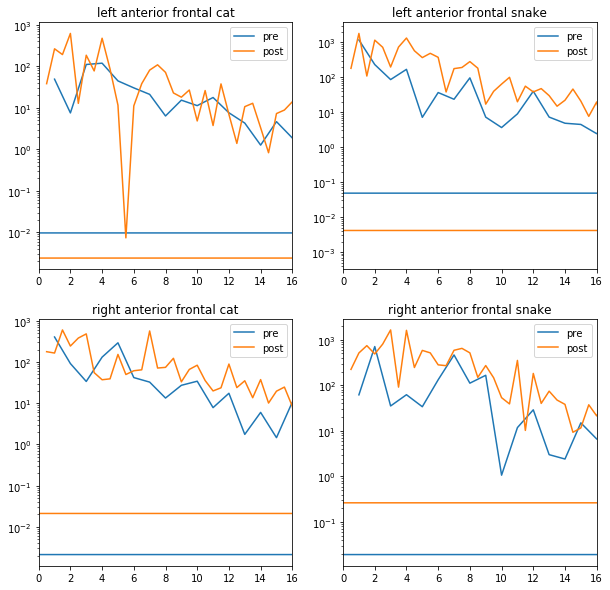

In [58]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(fft_freqs_pre[1:],cat_power_pre[1][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],cat_power_post[1][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.title('left anterior frontal cat')
plt.legend()

plt.subplot(2,2,2)
plt.plot(fft_freqs_pre[1:],snake_power_pre[1][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],snake_power_post[1][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.title('left anterior frontal snake')
plt.legend()


plt.subplot(2,2,3)
plt.plot(fft_freqs_pre[1:],cat_power_pre[3][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],cat_power_post[3][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.title('right anterior frontal cat')
plt.legend()

plt.subplot(2,2,4)
plt.plot(fft_freqs_pre[1:],snake_power_pre[3][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],snake_power_post[3][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.title('right anterior frontal snake')
plt.legend()

## Correlation

In [46]:
from scipy import stats
def pearson (x,y):
    return stats.pearsonr(x, y)

In [47]:
for i in range(0,len(channal_name)): 
    print('The Pearson correlation is: '+ str(pearson(cat_average[i],snake_average[i]))+' in electrode '+str(i+1)+' '+ channal_name[i])

The Pearson correlation is: (0.2756427634396017, 4.005947220518622e-08) in electrode 1 TP_L
The Pearson correlation is: (-0.2554129154827942, 3.9134363352853284e-07) in electrode 2 IF_L
The Pearson correlation is: (-0.37283338878838285, 4.1448671354675904e-14) in electrode 3 IF_R
The Pearson correlation is: (0.19245883529188357, 0.00014785408550480817) in electrode 4 TP_R
The Pearson correlation is: (0.2461877754795997, 1.03998175292904e-06) in electrode 5 BASELINE


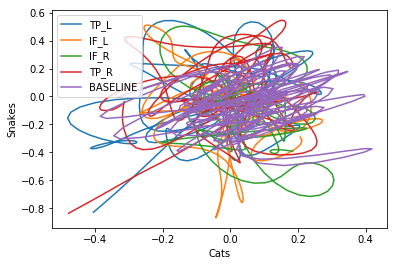

In [48]:
for i in range(0,len(channal_name)): 
    plt.plot(cat_average[i],snake_average[i], label=channal_name[i])
    plt.legend()
    plt.xlabel('Cats')
    plt.ylabel('Snakes')

(0.6731361340213627, 1.7616050558493896e-102)


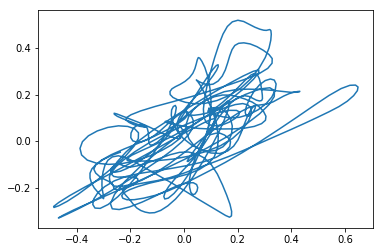

In [68]:
print(pearson(cat_average[0],cat_average[3]))
plt.plot(cat_average[0],cat_average[3])

(-0.3037795206007518, 7.36111928024816e-18)


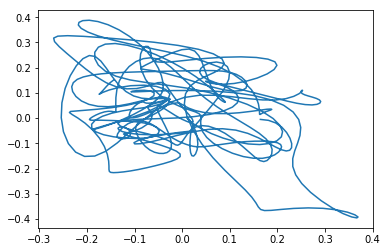

In [69]:
print(pearson(cat_average[1],cat_average[2]))
plt.plot(cat_average[1],cat_average[2])

(0.6128373243685971, 2.1968170981051522e-80)


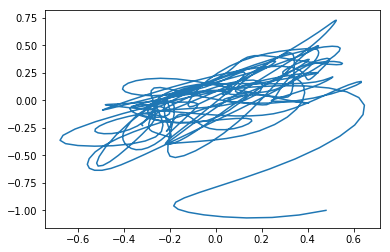

In [70]:
print(pearson(snake_average[0],snake_average[3]))
plt.plot(snake_average[0],snake_average[3])

(-0.1516760591959221, 2.4325569164694198e-05)


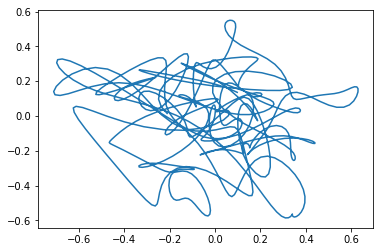

In [71]:
print(pearson(snake_average[1],snake_average[2]))
plt.plot(snake_average[1],snake_average[2])

## Coherence

In [49]:
participant = 0
max_freq = 3
chan = 0

In [60]:
def plot_spectrogram(spg, t, f, freq_lims=[0,100], plot_db=False):
    """
    Utility function for plotting the spectrogram for you.
    
    spg: spectrogram, 2D real-numbered array, dimensions are [frequency x time]
    t: time axis of spectrogram
    f: frequency axis of spectrogram
    freq_lims (optional): limits the frequency axis, defaults to 0-100Hz
    """
    plt.figure(figsize=(15,4))
    if plot_db:
        plt.imshow(10*np.log10(spg), aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    else:
        plt.imshow(spg, aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    plt.xlabel('Time'); plt.ylabel('Frequency(Hz)');
    plt.ylim(freq_lims)
    plt.colorbar()
    plt.tight_layout()

max freq =  4
257


(257, 170)

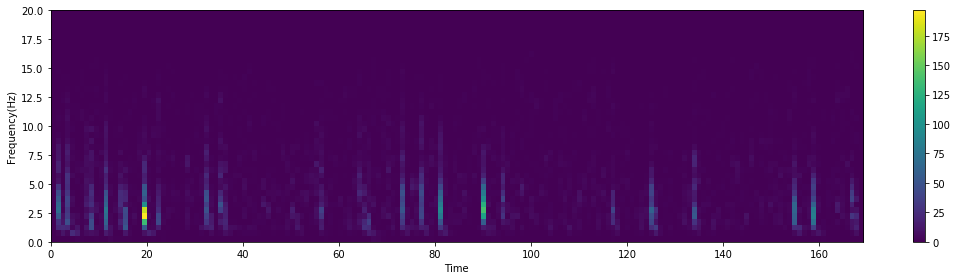

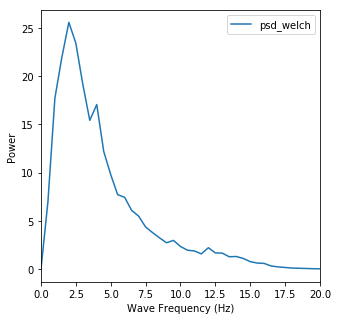

In [61]:
len_win = 2
len_overlap = 1
f_stft, t_stft, stft = signal.stft(np.array(eeg_list)[participant][chan], fs, nperseg=fs*len_win,  noverlap=fs*len_overlap, detrend=False)
spg = np.abs(stft)**2
# use plot_spectrogram
plot_spectrogram((spg), t_stft, f_stft, plot_db=False, freq_lims=[0,20])

# computing welch's spectrogram for you
f_welch, p_welch = signal.welch(np.array(eeg_list)[participant][chan],fs,window='boxcar',nperseg=int(fs*len_win),noverlap=int(fs*len_overlap))
p_welch *= 0.5*len_win # again, undoing scipy's normalization
# plot the PSDs
plt.figure(figsize=(5,5))
plt.plot(f_stft, p_welch, '-', alpha=1, label='psd_welch')
print("max freq = ", np.argmax(p_welch))
max_freq =  np.argmax(p_welch)
plt.legend()
plt.xlim([0,20]);
plt.ylabel('Power')
plt.xlabel('Wave Frequency (Hz)');
print(len(stft))
stft.shape

In [62]:
def get_coherence_all_freq( f_stft, t_stft, stft, participant,len_win, len_overlap   ):
    
    f_ind = np.arange(0,len(f_stft))

    cat_times = np.array(cat_index[participant] )/ fs
    cat_times = cat_times.astype(int)
    snake_time = np.array(snake_index[participant] )/ fs
    snake_time = snake_time.astype(int)


    #plt.figure(figsize=(5,5))
   # plt.xlabel('Real'); plt.ylabel('Imag')
    normelised_sum = 0
    # plot all trial vectors
    for trial_ind in cat_times - 1:
        X_trial = stft[f_ind, trial_ind].squeeze()
        # normalize by vector length
        X_trial /= np.abs(X_trial)
        normelised_sum += X_trial



    X_mean = normelised_sum / len(cat_times)

  #  plt.plot([0,X_mean.real], [0, X_mean.imag], 'ko-', alpha=1)

    coherence = np.abs(X_mean)#_YOUR_CODE_HERE
    coherence_cat_pre =coherence


    # ---------- now do it for real -------------------
    # get trial indices from trial times

    normelised_sum = 0
    for trial_ind in cat_times:
        X_trial = stft[f_ind, trial_ind].squeeze()

        # normalize by vector length
        X_trial /= np.abs(X_trial)
        normelised_sum += X_trial

     #   plt.plot([0,X_trial.real], [0, X_trial.imag], 'r.--', alpha=0.2)

    X_mean = normelised_sum / len(cat_times)

 #   plt.plot([0,X_mean.real], [0, X_mean.imag], 'ro-', alpha=1)

    coherence = np.abs(X_mean)#_YOUR_CODE_HERE
    coherence_cat_post = coherence



    normelised_sum = 0
    for trial_ind in snake_time - 1:
        X_trial = stft[f_ind, trial_ind].squeeze()

        # normalize by vector length
        X_trial /= np.abs(X_trial)
        normelised_sum += X_trial

     #   plt.plot([0,X_trial.real], [0, X_trial.imag], 'b.--', alpha=0.2)

    X_mean = normelised_sum / len(snake_time)

   # plt.plot([0,X_mean.real], [0, X_mean.imag], 'bo-', alpha=1)

    coherence = np.abs(X_mean)#_YOUR_CODE_HERE
    coherence_snake_pre = coherence
    
    normelised_sum = 0
    for trial_ind in snake_time:
        X_trial = stft[f_ind, trial_ind].squeeze()

        # normalize by vector length
        X_trial /= np.abs(X_trial)
        normelised_sum += X_trial

       # plt.plot([0,X_trial.real], [0, X_trial.imag], 'b.--', alpha=0.2)

    X_mean = normelised_sum / len(snake_time)

    #plt.plot([0,X_mean.real], [0, X_mean.imag], 'bo-', alpha=1)

    coherence = np.abs(X_mean)#_YOUR_CODE_HERE
    coherence_snake_post = coherence
    
    return (coherence_cat_pre,coherence_cat_post,coherence_snake_pre, coherence_snake_post)


## Get coherence for each person and for each channal

In [64]:
coherence_cat_pre = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
coherence_snake_pre = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
coherence_cat_post = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
coherence_snake_post = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
psd = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]

for participant in np.arange(len(eeg_list)):
    for c in range(0,5):
        f_stft, t_stft, stft = signal.stft(np.array(eeg_list)[participant][c], fs, nperseg=fs*len_win,  noverlap=fs*len_overlap, detrend=False)
        spg = np.abs(stft)**2
        psd[participant][c] = np.mean(spg, axis=1) 
        cat_pre, snake_pre, cat_post, snake_post = get_coherence_all_freq(f_stft, t_stft, stft, participant,1,0.5)
        coherence_cat_pre[participant][c] = (cat_pre)
        coherence_snake_pre[participant][c] = (snake_pre)
        coherence_cat_post[participant][c] = (cat_post)
        coherence_snake_post[participant][c] = (snake_post)


In [65]:
coherence_cat_pre = np.array(coherence_cat_pre)
coherence_snake_pre = np.array(coherence_snake_pre)
coherence_cat_post = np.array(coherence_cat_post)
coherence_snake_post = np.array(coherence_snake_post)
psd = np.array(psd)
psd.shape


(5, 5, 257)

In [66]:
coherence_cat_pre = np.mean(coherence_cat_pre, axis =0)
coherence_snake_pre = np.mean(coherence_snake_pre, axis =0)
coherence_cat_post = np.mean(coherence_cat_post, axis =0)
coherence_snake_post = np.mean(coherence_snake_post, axis =0)
psd = np.mean(psd, axis =0)

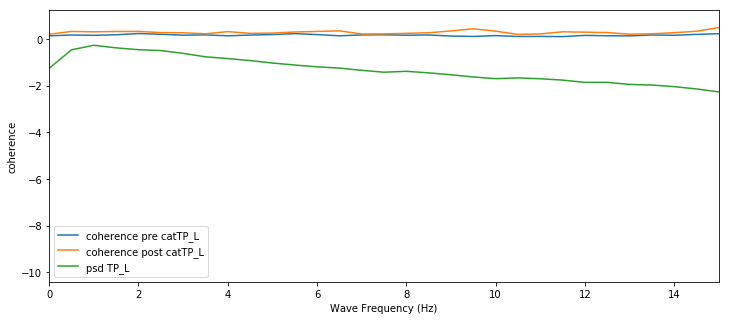

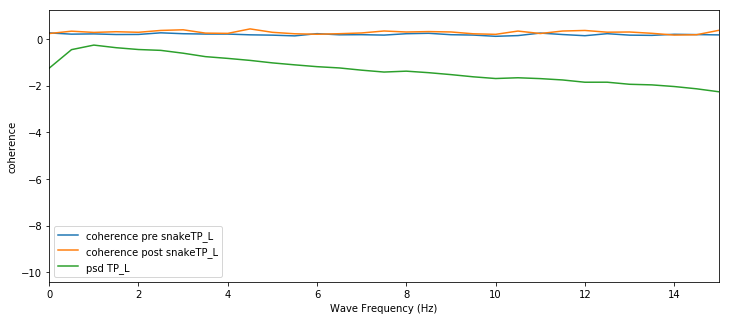

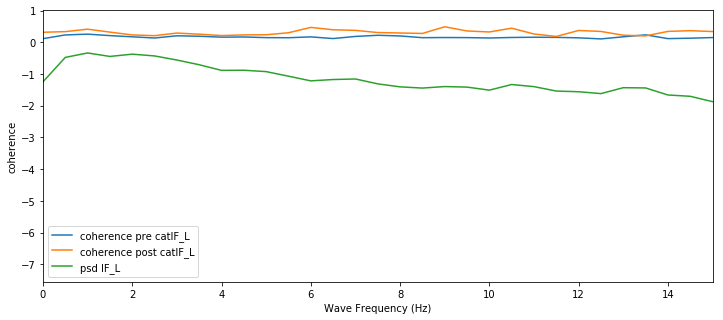

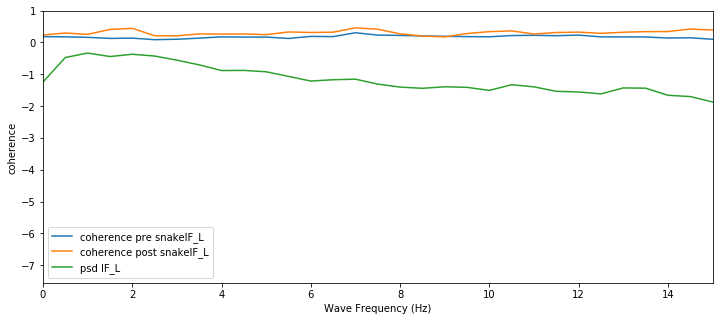

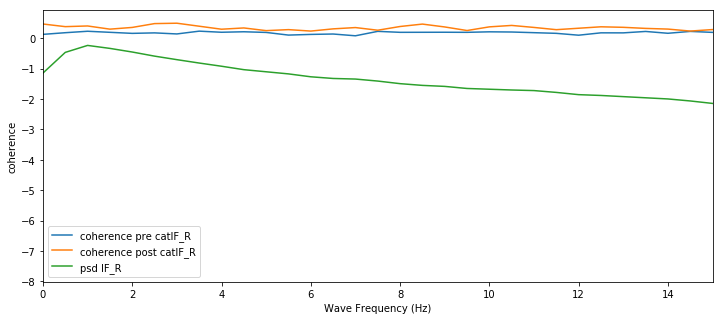

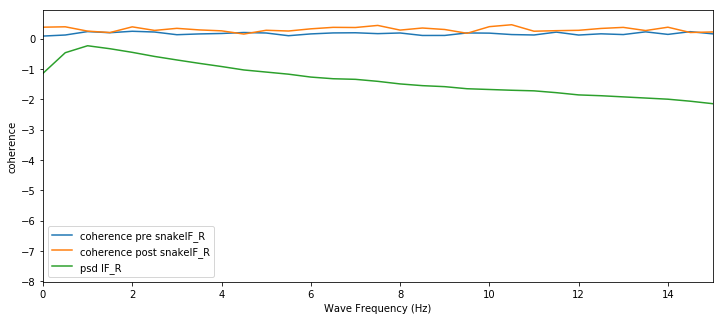

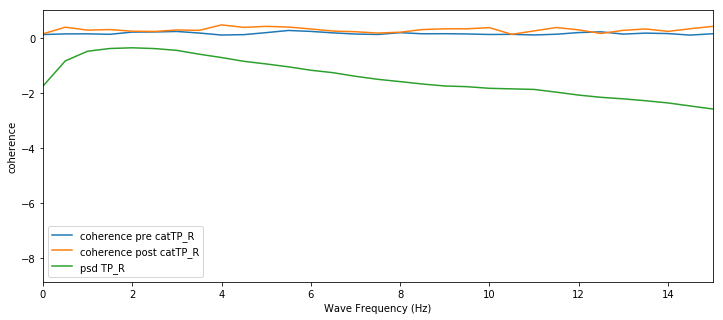

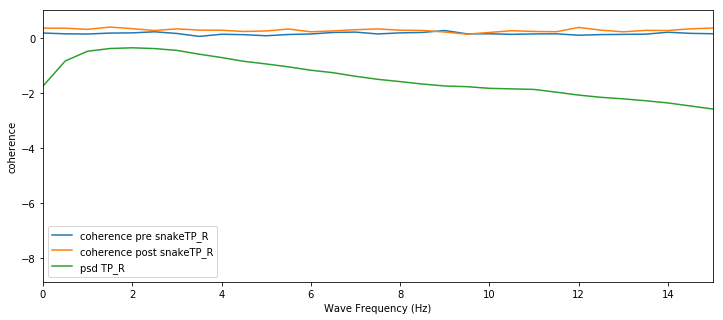

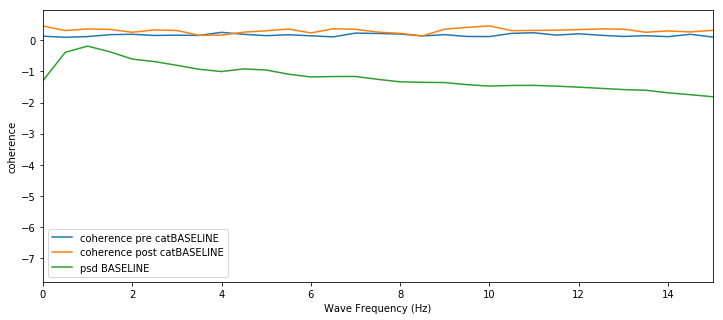

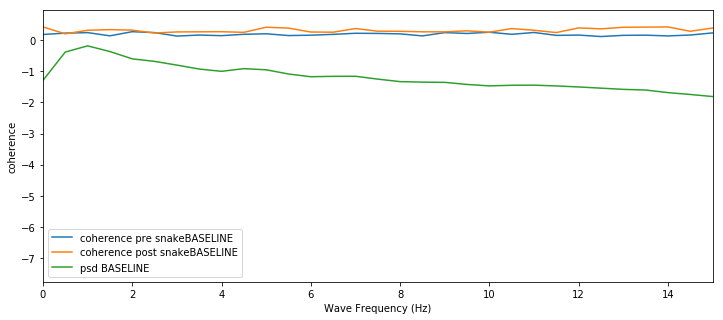

In [72]:
for i in range(0,len(channal_name)):

    #psd[i] /= np.linalg.norm(psd[i])

    plt.figure(figsize=(12,5))
    plt.plot(f_stft, coherence_cat_pre[i], '-', alpha=1, label='coherence pre cat'+ channal_name[i])
    plt.plot(f_stft, coherence_cat_post[i], '-', alpha=1, label='coherence post cat'+ channal_name[i])
    plt.plot(f_stft, np.log10(psd[i]), '-', alpha=1, label='psd '+ channal_name[i])


    plt.legend()
    plt.xlim([0,15]);
    #plt.ylim([-1,1]);
    plt.ylabel('coherence')
    plt.xlabel('Wave Frequency (Hz)');

    plt.figure(figsize=(12,5))
    plt.plot(f_stft, coherence_snake_pre[i], '-', alpha=1, label='coherence pre snake'+ channal_name[i])
    plt.plot(f_stft, coherence_snake_post[i], '-', alpha=1, label='coherence post snake'+ channal_name[i])
    plt.plot(f_stft, np.log10(psd[i]), '-', alpha=1, label='psd '+ channal_name[i])

    plt.legend()
    plt.xlim([0,15]);
   # plt.ylim([-1,1]);

    plt.ylabel('coherence')
    plt.xlabel('Wave Frequency (Hz)');